# import, data read

In [ ]:
import pandas as pd, numpy as np
import scipy
import matplotlib.pyplot as plt

In [218]:
df = pd.read_csv('market_data_binance.by_minute_ALL_2022-09-19T04:00:00Z_2022-09-20T03:59:00Z.csv')
df['time'] = pd.to_datetime(df['timestamp'],unit='s')
df_close = df.pivot(index='time', columns='symbol', values='close').resample('10min').last()

In [237]:
df_close.mean().sort_values()[-10:]

symbol
AUTOUSDT      233.493750
BNBUSDT       265.583333
BIFIUSDT      345.340278
MKRUSDT       624.076389
YFIIUSDT      867.563889
ETHUSDT      1336.274097
PAXGUSDT     1661.451389
YFIUSDT      8373.729167
BTCUSDT     19049.317500
WBTCBUSD    19053.174514
dtype: float64

In [287]:
symbols = ['YFIIUSDT', 'ETHUSDT', 'PAXGUSDT', 'BIFIUSDT', 'BNBUSDT']
df_close_symbols = df_close[symbols]

In [288]:
df_close_symbols

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
time,,,,,
2022-09-19 04:00:00,834.2,1300.92,1659.0,340.1,262.3
2022-09-19 04:10:00,834.6,1303.61,1659.0,340.1,262.3
2022-09-19 04:20:00,835.4,1303.85,1660.0,343.0,261.9
2022-09-19 04:30:00,835.0,1304.09,1659.0,341.3,261.3
2022-09-19 04:40:00,837.4,1305.19,1659.0,341.7,261.3
...,...,...,...,...,...
2022-09-20 03:10:00,879.8,1349.10,1666.0,345.6,268.2
2022-09-20 03:20:00,874.4,1344.29,1666.0,344.5,267.9
2022-09-20 03:30:00,879.8,1349.84,1667.0,344.6,268.6


# Sanity check: eigen values, vectors

In [240]:
eiven_vals, eigen_vecs = np.linalg.eig([[1, 2, 0], [2, 1, 0], [0, 0, 4]])

In [190]:
eiven_vals

array([ 3., -1.,  4.])

In [191]:
eigen_vecs

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].

In [193]:
eigen_vecs[:,0]

array([0.70710678, 0.70710678, 0.        ])

note that the matrix represenation is bit confusing. v[i,:] is *not* eigenvector, but v[:,i] is.

In [194]:
eigen_vecs[0]

array([ 0.70710678, -0.70710678,  0.        ])

and accordingly the eigenvalues matix on the rhs is to be horizontally layed down.

In [195]:
eigen_vecs @ np.diag(eiven_vals) @ eigen_vecs.T

array([[1., 2., 0.],
       [2., 1., 0.],
       [0., 0., 4.]])

# Solve the minimal predictability condition

In [290]:
df_close_symbols.corr().style.background_gradient(cmap='coolwarm')

symbol,YFIIUSDT,ETHUSDT,PAXGUSDT,BIFIUSDT,BNBUSDT
symbol,,,,,
YFIIUSDT,1.000000,0.950428,0.818159,0.932186,0.927611
ETHUSDT,0.950428,1.000000,0.921066,0.945962,0.968835
PAXGUSDT,0.818159,0.921066,1.000000,0.831618,0.920978
BIFIUSDT,0.932186,0.945962,0.831618,1.000000,0.939282
BNBUSDT,0.927611,0.968835,0.920978,0.939282,1.000000


In [322]:
def calc_autocov_matrix(arr, lag):
    m = arr.shape[0]  # sample size.
    return 1 / (m - lag - 1) * (arr[lag:] - np.nanmean(arr[lag:], axis=0)).T @ (arr[:m-lag] - np.nanmean(arr[:m-lag], axis=0))

In [307]:
cov_matrix = df_close_symbols.cov()
inv_cov_matrix = np.linalg.inv(cov_matrix)
inv_sqrt_cov_matrix = scipy.linalg.sqrtm(inv_cov_matrix)
autocov_matrix = calc_autocov_matrix(df_close_symbols.values, 1)

In [308]:
autocov_matrix

array([[357.05666531, 532.81806961,  74.9103554 ,  75.90236744,
         74.71295351],
       [545.85125153, 888.4023293 , 134.85295646, 122.93908638,
        123.81087196],
       [ 80.13075837, 139.45899764,  24.27648962,  18.3625089 ,
         20.02076894],
       [ 77.32088074, 121.13087726,  17.45393104,  17.8956615 ,
         17.30766905],
       [ 77.41449694, 124.96202146,  19.44085404,  17.59892785,
         18.44277973]])

In [309]:
var_predictability_matrix = inv_sqrt_cov_matrix @ autocov_matrix @ cov_matrix @ autocov_matrix.T @ inv_sqrt_cov_matrix.T

In [310]:
var_predictability_matrix

,0,1,2,3,4
0,360292.428228,6.500186e+05,124873.850608,101667.895069,116391.881519
1,650018.619009,1.174820e+06,226003.364110,183569.411505,210287.280346
2,124873.850608,2.260034e+05,43527.297062,35285.852407,40444.052917
3,101667.895069,1.835694e+05,35285.852407,28700.017550,32864.950927
4,116391.881519,2.102873e+05,40444.052917,32864.950927,37644.767039


In [311]:
var_eigen_vals, var_eigen_vecs = np.linalg.eig(var_predictability_matrix)

In [312]:
var_eigen_vecs @ np.diag(var_eigen_vals) @ var_eigen_vecs.T

array([[ 360292.42822794,  650018.61900913,  124873.85060823,
         101667.89506882,  116391.88151896],
       [ 650018.61900913, 1174819.73418825,  226003.36411046,
         183569.41150473,  210287.28034598],
       [ 124873.85060823,  226003.36411046,   43527.29706211,
          35285.8524067 ,   40444.05291717],
       [ 101667.89506882,  183569.41150473,   35285.8524067 ,
          28700.0175504 ,   32864.95092745],
       [ 116391.88151896,  210287.28034598,   40444.05291717,
          32864.95092745,   37644.76703904]])

In [313]:
minimal_var_eigen_vec = var_eigen_vecs[:,np.argmin(var_eigen_vals)]
maximal_var_eigen_vec = var_eigen_vecs[:,np.argmax(var_eigen_vals)]

In [314]:
var_eigen_vals

array([1.64440360e+06, 5.74579494e+02, 4.41534630e+00, 1.55691725e+00,
       9.19775205e-02])

In [315]:
minimal_var_eigen_vec

array([-0.03776745,  0.09885796, -0.39922335, -0.68929468,  0.59522624])

In [316]:
maximal_var_eigen_vec

array([0.46782485, 0.84520848, 0.16254804, 0.13209435, 0.15130023])

<Axes: xlabel='time'>

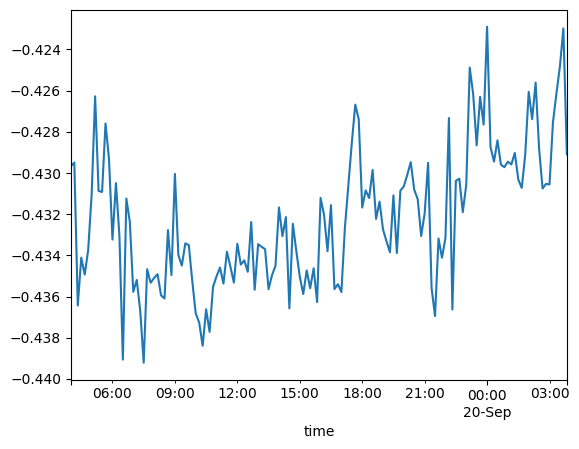

In [317]:
((df_close_symbols / df_close_symbols.mean()) * minimal_var_eigen_vec).sum(axis=1).plot()

<Axes: xlabel='time'>

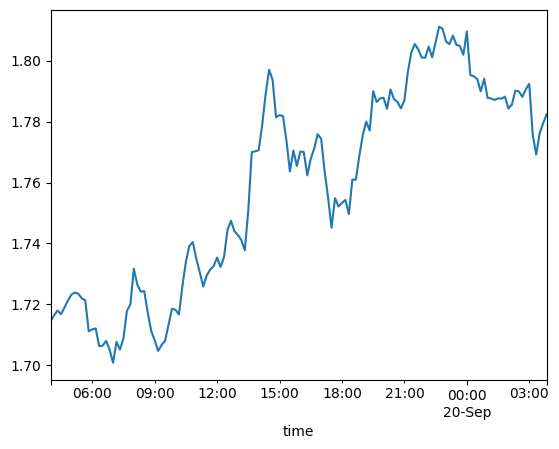

In [318]:
((df_close_symbols / df_close_symbols.mean()) * maximal_var_eigen_vec).sum(axis=1).plot()

<Axes: xlabel='time'>

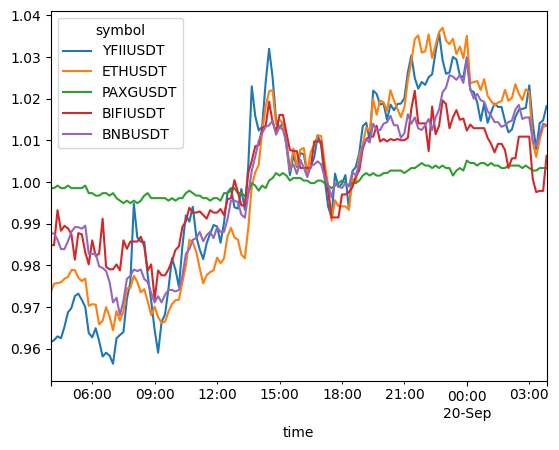

In [319]:
(df_close_symbols / df_close_symbols.mean()).plot()

# rolling based

In [179]:
df_close_symbols.rolling(60).corr()

symbol                         1INCHUSDT  AAVEUSDT   ACAUSDT
time                symbol                                  
2022-09-19 04:00:00 1INCHUSDT        NaN       NaN       NaN
                    AAVEUSDT         NaN       NaN       NaN
                    ACAUSDT          NaN       NaN       NaN
2022-09-19 04:10:00 1INCHUSDT        NaN       NaN       NaN
                    AAVEUSDT         NaN       NaN       NaN
...                                  ...       ...       ...
2022-09-20 03:40:00 AAVEUSDT    0.776689  1.000000 -0.159291
                    ACAUSDT    -0.316365 -0.159291  1.000000
2022-09-20 03:50:00 1INCHUSDT   1.000000  0.731317 -0.352196
                    AAVEUSDT    0.731317  1.000000 -0.170656
                    ACAUSDT    -0.352196 -0.170656  1.000000

[432 rows x 3 columns]